Data loading

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import regex as re
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt


file_name = "training_dataset_windowed_days_90"
data_path = f'/workspaces/msc_thesis/data/final_data/{file_name}.csv'

figure_base_path = f"/workspaces/msc_thesis/data/figures/modelling/{file_name}/"
if not os.path.exists(figure_base_path):
    os.makedirs(figure_base_path)


def safe_save_fig(output_path):
    """Helper method to safe figures in a potentially non-existent directory."""
    dir_name = os.path.dirname(output_path)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    plt.savefig(output_path)


df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)


print(f'Total entries: {len(df)}.')

print(f'{df.columns=}')

df.describe()

# The number of headers containing metadata; i.e., the stuff that's unusable for inference.
meta_header_count = 4
pr_merged_key = 'PullRequestIsMerged'


Total entries: 1848492.
df.columns=Index(['ID', 'Project Name', 'PR Number', 'Closed At',
       'ControlIntegratedBySameUser', 'ControlPullRequestLifeTimeInMinutes',
       'ControlPullRequestHasComments', 'ControlNumberOfCommitsInPullRequest',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'PullRequestIsMerged',
       'SubmitterIsFirstTimeContributor',
       'ControlIntraProjectPullRequestExperienceOfIntegrator',
       'ControlIntraProjectPullRequestSuccessRateSubmitter',
       'SubmitterEcosystemExperiencePullRequestSubmissionCount',
       'SubmitterEcosystemExperiencePullRequestSuccessRate',
       'SubmitterEcosystemExperiencePullRequestCommentCount',
       'SubmitterEcosystemExperiencePullRequestDiscussionParticipationCount',
       'SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
       'SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter',
       'SharedExperiencePullRequestSubmittedB

Drop irrelevant fields and perform log-transform on the relevant fields.

In [3]:
removed_fields = [
    "SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter",
    "SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator",
    "SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter",
    "SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter",
    "SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator",
    # NOTE: although this is called "PR", it does actually track comments on issues.
    # It's just named incorrectly.
    "SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter.1", 

    "SubmitterDependencyEcosystemExperienceIssueCommentCount",
    "SubmitterDependencyEcosystemExperienceIssueDiscussionParticipationCount",
    "SubmitterDependencyEcosystemExperienceIssueSubmissionCount",

    "SubmitterDependencyEcosystemExperiencePullRequestDiscussionParticipationCount",  # duplicate
    "SubmitterEcosystemExperienceIssueDiscussionParticipationCount",  # duplicate
    "SubmitterEcosystemExperiencePullRequestDiscussionParticipationCount",  # duplicate

    "SubmitterInversedDependencyEcosystemExperienceIssueCommentCount",
    "SubmitterInversedDependencyEcosystemExperienceIssueDiscussionParticipationCount",
    "SubmitterInversedDependencyEcosystemExperienceIssueSubmissionCount",
    "SubmitterInversedDependencyEcosystemExperiencePullRequestDiscussionParticipationCount",  # duplicate
]

log_transformed_fields = [
    "ControlIntraProjectPullRequestExperienceOfIntegrator",
    "ControlNumberOfCommitsInPullRequest",
    "ControlPullRequestLifeTimeInMinutes",

    "SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter",
    "SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator",

    "SubmitterDependencyEcosystemExperiencePullRequestCommentCount",
    "SubmitterDependencyEcosystemExperiencePullRequestSubmissionCount",

    "SubmitterEcosystemExperienceIssueCommentCount",
    "SubmitterEcosystemExperienceIssueSubmissionCount",
    "SubmitterEcosystemExperiencePullRequestCommentCount",
    "SubmitterEcosystemExperiencePullRequestSubmissionCount",

    "SubmitterInversedDependencyEcosystemExperiencePullRequestCommentCount",
    "SubmitterInversedDependencyEcosystemExperiencePullRequestSubmissionCount",
]

binary_fields = [
    "ControlHasHashTagInDescription",
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlPullRequestHasComments",
    "SubmitterIsFirstTimeContributor",
]

print(f'{len(removed_fields)=}')
print(f'{len(binary_fields)=}')
print(f'{len(log_transformed_fields)=}')

new_log_transformed_fields = []
for field in log_transformed_fields:
    new_field_name = f'log10(1 + {field})'
    new_log_transformed_fields.append(new_field_name)
    df[new_field_name] = np.log10(1 + df[field])

print(f'{df.columns=}')
print(f'{df.columns[df.isna().any()].tolist()=}')
df = df.dropna()

len(removed_fields)=15
len(binary_fields)=5
len(log_transformed_fields)=13


/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


df.columns=Index(['ID', 'Project Name', 'PR Number', 'Closed At',
       'ControlIntegratedBySameUser', 'ControlPullRequestLifeTimeInMinutes',
       'ControlPullRequestHasComments', 'ControlNumberOfCommitsInPullRequest',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'PullRequestIsMerged',
       'SubmitterIsFirstTimeContributor',
       'ControlIntraProjectPullRequestExperienceOfIntegrator',
       'ControlIntraProjectPullRequestSuccessRateSubmitter',
       'SubmitterEcosystemExperiencePullRequestSubmissionCount',
       'SubmitterEcosystemExperiencePullRequestSuccessRate',
       'SubmitterEcosystemExperiencePullRequestCommentCount',
       'SubmitterEcosystemExperiencePullRequestDiscussionParticipationCount',
       'SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
       'SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter',
       'SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByI

Distribution plots before log-transform.

ControlIntegratedBySameUser
ControlPullRequestLifeTimeInMinutes
ControlPullRequestHasComments
ControlNumberOfCommitsInPullRequest
ControlPullRequestHasCommentByExternalUser
ControlHasHashTagInDescription
PullRequestIsMerged
SubmitterIsFirstTimeContributor
ControlIntraProjectPullRequestExperienceOfIntegrator
ControlIntraProjectPullRequestSuccessRateSubmitter
SubmitterEcosystemExperiencePullRequestSubmissionCount
SubmitterEcosystemExperiencePullRequestSuccessRate
SubmitterEcosystemExperiencePullRequestCommentCount
SubmitterEcosystemExperiencePullRequestDiscussionParticipationCount
SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator
SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter
SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator
SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter
SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter
SubmitterDependencyEcosystemExperiencePullRequestSubmissi

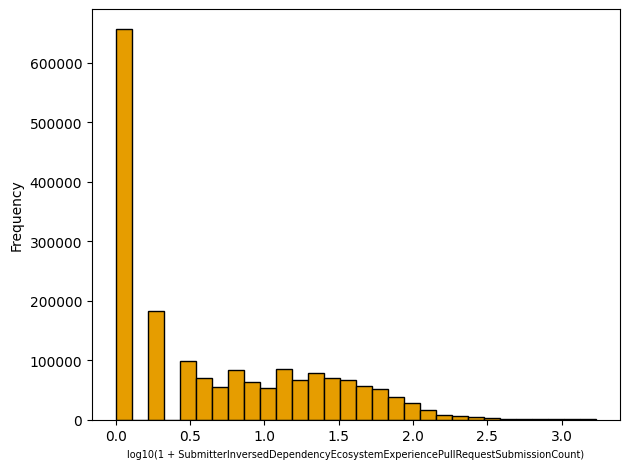

In [4]:
import copy
# shown_fields_without_zeroes = [
#     *log_transformed_fields,
#     *new_log_transformed_fields
# ]
# rx = r'.*(NumberOfCommitsInPullRequest|PullRequestLifeTimeInMinutes).*'
# shown_fields_without_zeroes = set([entry for entry in shown_fields_without_zeroes
#                                    if len(list(re.finditer(rx, entry))) == 0])
# print(f'{shown_fields_without_zeroes=}')

default_plot_settings = {
    'edgecolor': 'black',
    'color': "#e69d00"
}

default_plot_settings_2 = copy.deepcopy(default_plot_settings)
default_plot_settings_2['color'] = "#56b3e9"


def __fix_x_label_fontsize():
    # Adjusts x-label's fontsize to fit the text.
    fig = plt.gcf()
    fig_width = fig.get_figwidth()
    xlabel_fontsize = int(fig_width * 100 / len(column))
    ax = plt.gca()
    orig_fontsize = ax.xaxis.label.get_fontsize()
    ax.xaxis.label.set_fontsize(min(xlabel_fontsize, orig_fontsize))


# Iterate over the columns and generate histograms
for column in df.columns[meta_header_count:]:
    print(column)
    plt.clf()
    entries = df[column]

    if column in binary_fields or column == pr_merged_key:
        entries = df[column].replace({False: 0, True: 1})
        plt.xticks(entries.value_counts().index, ['False', 'True'])
        plt.hist(entries, bins=2, **default_plot_settings)
        plt.ylabel('Frequency')
    # elif column in shown_fields_without_zeroes:
    #     _, bins, _ = plt.hist(entries, bins=30, alpha=1,
    #              label="All Data", **default_plot_settings)
    #     ax:plt.Axes = plt.gca()
    #     ax.set_ylabel("Frequency")
    #     ax.set_xlabel(column)
    #     __fix_x_label_fontsize()

    #     filtered_data = df[column][df[column] != 0]
    #     ax2 = ax.twinx()

    #     ax2.hist(filtered_data, bins, alpha=0.5,
    #              label='Excl. zeroes',**default_plot_settings_2)
    #     ax2.set_ylabel("Frequency (Excl. Zeroes)")
    #     ax2.set_zorder(10)
    #     plt.tight_layout()
    else:
        plt.hist(entries, bins=30, **default_plot_settings)
        plt.ylabel('Frequency')

    plt.xlabel(column)
    __fix_x_label_fontsize()
    plt.tight_layout()

    safe_save_fig(f"{figure_base_path}/distributions/{column}.png")


Drops the original log-transformed and unusable fields.

In [5]:
df = df.drop(removed_fields, axis=1)
df = df.drop(log_transformed_fields, axis=1)

df.describe()

,ID,PR Number,ControlIntraProjectPullRequestSuccessRateSubmitter,SubmitterEcosystemExperiencePullRequestSuccessRate,SubmitterDependencyEcosystemExperiencePullRequestSuccessRate,SubmitterInversedDependencyEcosystemExperiencePullRequestSuccessRate,SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter.1,log10(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),log10(1 + ControlNumberOfCommitsInPullRequest),log10(1 + ControlPullRequestLifeTimeInMinutes),log10(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter),log10(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),log10(1 + SubmitterDependencyEcosystemExperiencePullRequestCommentCount),log10(1 + SubmitterDependencyEcosystemExperiencePullRequestSubmissionCount),log10(1 + SubmitterEcosystemExperienceIssueCommentCount),log10(1 + SubmitterEcosystemExperienceIssueSubmissionCount),log10(1 + SubmitterEcosystemExperiencePullRequestCommentCount),log10(1 + SubmitterEcosystemExperiencePullRequestSubmissionCount),log10(1 + SubmitterInversedDependencyEcosystemExperiencePullRequestCommentCount),log10(1 + SubmitterInversedDependencyEcosystemExperiencePullRequestSubmissionCount)
count,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06,1848483.0,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06,1.848483e+06
mean,1.476446e+08,3.788417e+03,5.334602e-01,3.742976e-01,5.334602e-01,5.334602e-01,0.0,1.489512e+00,4.740259e-01,2.832128e+00,4.232715e-02,2.038921e-01,6.364527e-01,6.857387e-01,8.665015e-01,4.494457e-01,4.774533e-01,4.375546e-01,6.364527e-01,6.857387e-01
std,1.004344e+08,8.027204e+03,4.627121e-01,4.477230e-01,4.627121e-01,4.627121e-01,0.0,8.909838e-01,2.938880e-01,1.430906e+00,2.011265e-01,4.242759e-01,7.385602e-01,6.791594e-01,8.155790e-01,5.030887e-01,6.696130e-01,6.050725e-01,7.385602e-01,6.791594e-01
min,6.870000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,-6.989700e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.828347e+07,9.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,7.781513e-01,3.010300e-01,1.728624e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.374030e+08,5.380000e+02,8.000000e-01,0.000000e+00,8.000000e-01,8.000000e-01,0.0,1.477121e+00,3.010300e-01,2.991964e+00,0.000000e+00,0.000000e+00,3.010300e-01,4.771213e-01,6.989700e-01,3.010300e-01,0.000000e+00,0.000000e+00,3.010300e-01,4.771213e-01
75%,2.280283e+08,2.817000e+03,1.000000e+00,9.215686e-01,1.000000e+00,1.000000e+00,0.0,2.152288e+00,6.020600e-01,3.865695e+00,0.000000e+00,3.010300e-01,1.204120e+00,1.255273e+00,1.531479e+00,7.781513e-01,9.030900e-01,7.781513e-01,1.204120e+00,1.255273e+00
max,3.617756e+08,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,3.631647e+00,4.000043e+00,6.652197e+00,2.741939e+00,2.744293e+00,3.309417e+00,3.231470e+00,3.885192e+00,3.368473e+00,3.113609e+00,3.006894e+00,3.309417e+00,3.231470e+00


Downsamples the dataset in case you set ``sample`` to ``>0`` (for debugging).

In [6]:
sample_size = 0
if sample_size > 0:
    df = df.sample(sample_size)
    print("WARNING: TRAINING WITH SAMPLE!")

Selects predictor features and the dependent feature.

In [7]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = max(class_counts) / min(class_counts)
print(f'{class_counts=}')
print(f'{class_imbalance=}')

# Makes 80:20 dataset splits for testing/training
train, test = train_test_split(df, test_size=0.2)
print(f'{len(train)=}, {len(test)=}')

# Labels
train_labels = train[pr_merged_key]
test_labels = test[pr_merged_key]

# Predictors
used_predictors = df.columns[meta_header_count:].drop(pr_merged_key)
train_predictors = train[used_predictors]
test_predictors = test[used_predictors]
print(f'{len(used_predictors)=}')
print(f'{used_predictors=}')

class_counts=PullRequestIsMerged
True     1422696
False     425787
Name: count, dtype: int64
class_imbalance=3.3413326381500608
len(train)=1478786, len(test)=369697
len(used_predictors)=23
used_predictors=Index(['ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'SubmitterIsFirstTimeContributor',
       'ControlIntraProjectPullRequestSuccessRateSubmitter',
       'SubmitterEcosystemExperiencePullRequestSuccessRate',
       'SubmitterDependencyEcosystemExperiencePullRequestSuccessRate',
       'SubmitterInversedDependencyEcosystemExperiencePullRequestSuccessRate',
       'SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter.1',
       'log10(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'log10(1 + ControlNumberOfCommitsInPullRequest)',
       'log10(1 + ControlPullRequestLifeTimeInMinutes)',
       'log10(1 + SharedExperiencePullRequestSubmitt

## Random Forest

In [8]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Model creation and predictions.
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_predictors, train_labels)
predictions = rf.predict(test_predictors)
predictions = [pred >= 0.5 for pred in predictions]

# Absolute error
absolute_error = abs(predictions ^ test_labels)
print(f'Absolute error: {absolute_error}')

# F1 scores.
conf = confusion_matrix(test_labels, predictions)
imbalance_weight = list([1.0 if label else class_imbalance for label in test_labels])
f1 = f1_score(test_labels, predictions, sample_weight=imbalance_weight)
f1_without_imbalance =  f1_score(test_labels, predictions)
print(f'{f1=}')
print(f'{f1_without_imbalance=}')

# Other metrics.
print(f'{conf=}')
print(classification_report(test_labels, predictions, sample_weight=imbalance_weight))


Absolute error: 31143      False
1195179    False
1092286     True
701167      True
872004     False
           ...  
122252     False
1553896    False
119210     False
653537     False
945487     False
Name: PullRequestIsMerged, Length: 369697, dtype: bool
f1=0.8201561398398324
f1_without_imbalance=0.921329745099683
conf=array([[ 54454,  30796],
       [ 15187, 269260]])
              precision    recall  f1-score   support

       False       0.92      0.64      0.75 284848.6074021931
        True       0.72      0.95      0.82  284447.0

    accuracy                           0.79 569295.6074021931
   macro avg       0.82      0.79      0.79 569295.6074021931
weighted avg       0.82      0.79      0.79 569295.6074021931



Generates partial dependence plots.

It's visible that the intra-project experience completely overshadows other factors. 

When exclusing this, you can see that PR acceptance ratio matters as well as whether the PR has comments. 
Lifetime somehow has no effect whatsoever; ditto for the ecosystem PR count. 

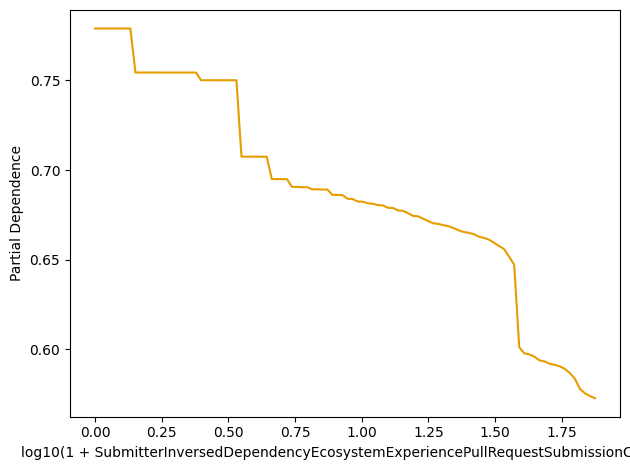

In [9]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt

average_only = True

if average_only:
    # Collective partial dependence plot.
    pdd = PartialDependenceDisplay.from_estimator(
        rf, test_predictors, used_predictors)

    fig = plt.gcf()
    axs = fig.axes

    lines = []
    for ax in axs:
        __lines = list([(line.get_xdata(), line.get_ydata())
                       for line in ax.lines])
        lines.extend(__lines)

    plt.clf()

    for (x, y), label in zip(lines, used_predictors):
        plt.clf()
        plt.plot(x, y, linestyle='-', color='#e69d00')
        plt.xlabel(label)
        plt.ylabel('Partial Dependence')
        plt.tight_layout()

        safe_save_fig(f"{figure_base_path}/partial-dependence/{column}.png")

else:
    # TODO: create a plot where the average response is displayed
    # as a line, and the min/max as a grey area around it.
    pdd = PartialDependenceDisplay.from_estimator(
        rf, test_predictors, used_predictors, kind='individual')


## Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_predictors, train_labels)

lr_predictions = lr.predict(test_predictors)

imbalance_weight = [1.0 if label else class_imbalance for label in test_labels]
mean_accuracy = lr.score(test_predictors, test_labels, sample_weight=imbalance_weight)
print(f'{mean_accuracy=}')

absolute_error = abs(predictions ^ test_labels)
print(f'{absolute_error=}')


lr_f1 = f1_score(test_labels, predictions, sample_weight=imbalance_weight)
lr_f1_without_imbalance = f1_score(test_labels, predictions)
print(f'{lr_f1=}')
print(f'{lr_f1_without_imbalance=}')

conf = confusion_matrix(test_labels, predictions)
print(f'{conf=}')

print(classification_report(test_labels, predictions, sample_weight=imbalance_weight))

mean_accuracy=0.6824955880636729
absolute_error=31143      False
1195179    False
1092286     True
701167      True
872004     False
           ...  
122252     False
1553896    False
119210     False
653537     False
945487     False
Name: PullRequestIsMerged, Length: 369697, dtype: bool
lr_f1=0.8201561398398324
lr_f1_without_imbalance=0.921329745099683
conf=array([[ 54454,  30796],
       [ 15187, 269260]])
              precision    recall  f1-score   support

       False       0.92      0.64      0.75 284848.6074021931
        True       0.72      0.95      0.82  284447.0

    accuracy                           0.79 569295.6074021931
   macro avg       0.82      0.79      0.79 569295.6074021931
weighted avg       0.82      0.79      0.79 569295.6074021931



In [ ]:
train_predictors[]

Calculates corresponding p-values for each feature.

In [16]:
import statsmodels.api as sm

value_mapper = {False: 0, True: 1}
for feature in binary_fields:
    train_predictors[feature] = train_predictors[feature].replace(value_mapper)
    test_predictors[feature] = test_predictors[feature].replace(value_mapper)

print(f'{len(train_predictors.columns)=}')
print(train_predictors.columns)
print(train_predictors)

sm_lr = sm.Logit(train_labels, train_predictors)
result = sm_lr.fit()

print(result.params)

predictions = result.predict(test_predictors)
predictions = [pred >= 0.5 for pred in predictions]

result.pred_table()

print('summary 1:')
result.summary()

print('summary 2:')
result.summary2()

/tmp/ipykernel_1908/3820197374.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_predictors[feature] = train_predictors[feature].replace(value_mapper)
/tmp/ipykernel_1908/3820197374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_predictors[feature] = test_predictors[feature].replace(value_mapper)


len(train_predictors.columns)=23
Index(['ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'SubmitterIsFirstTimeContributor',
       'ControlIntraProjectPullRequestSuccessRateSubmitter',
       'SubmitterEcosystemExperiencePullRequestSuccessRate',
       'SubmitterDependencyEcosystemExperiencePullRequestSuccessRate',
       'SubmitterInversedDependencyEcosystemExperiencePullRequestSuccessRate',
       'SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter.1',
       'log10(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'log10(1 + ControlNumberOfCommitsInPullRequest)',
       'log10(1 + ControlPullRequestLifeTimeInMinutes)',
       'log10(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)',
       'log10(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'log10(1 + SubmitterDependencyEcosy

LinAlgError: Singular matrix